In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import numpy as  np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
data = pd.read_csv('/gdrive/My Drive/Colab Notebooks/car_damage_detection/damage_detection')
data.head()

,image,class,subset
0,image/0.jpeg,multiple_damage,T
1,image/1.jpeg,head_lamp,T
2,image/2.jpeg,door_scratch,T
3,image/3.jpeg,head_lamp,T
4,image/4.jpeg,multiple_damage,T


In [ ]:

data.isnull().sum()

image     0
class     0
subset    0
dtype: int64

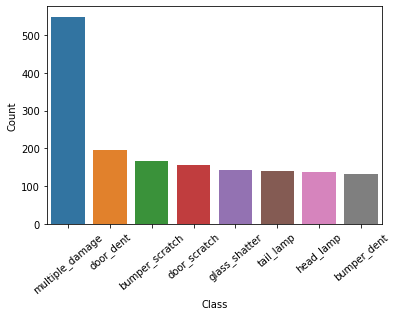

In [ ]:
counts = data['class'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=40);

In [ ]:
path = '/gdrive/My Drive/Colab Notebooks/car_damage_detection/'
def edit_path_img(x):
    return path + x

In [ ]:
data["image"] = data["image"].apply(edit_path_img)
data.head()

,image,class,subset
0,/gdrive/My Drive/Colab Notebooks/car_damage_de...,multiple_damage,T
1,/gdrive/My Drive/Colab Notebooks/car_damage_de...,head_lamp,T
2,/gdrive/My Drive/Colab Notebooks/car_damage_de...,door_scratch,T
3,/gdrive/My Drive/Colab Notebooks/car_damage_de...,head_lamp,T
4,/gdrive/My Drive/Colab Notebooks/car_damage_de...,multiple_damage,T


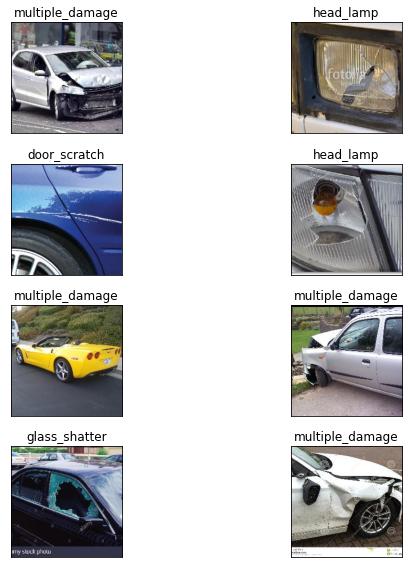

In [ ]:
datafig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.image[i]))
    ax.set_title(data['class'][i])
plt.tight_layout()
plt.show()

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.2)

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    seed=0
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=0
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1292 validated image filenames belonging to 8 classes.
Found 1292 validated image filenames belonging to 8 classes.
Found 324 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
pretrained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input
x = Dense(120, activation='relu')(pretrained_model.output)
x = Dense(120, activation='relu')(x)
outputs = Dense(8, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=my_callbacks)

Epoch 1/50
41/41 [==============================] - 605s 14s/step - loss: 1.2644 - accuracy: 0.5697 - val_loss: 0.7547 - val_accuracy: 0.7229
Epoch 2/50
41/41 [==============================] - 10s 244ms/step - loss: 0.5867 - accuracy: 0.7988 - val_loss: 0.3685 - val_accuracy: 0.8885
Epoch 3/50
41/41 [==============================] - 10s 244ms/step - loss: 0.3838 - accuracy: 0.8684 - val_loss: 0.2286 - val_accuracy: 0.9396
Epoch 4/50
41/41 [==============================] - 10s 242ms/step - loss: 0.2583 - accuracy: 0.9234 - val_loss: 0.2085 - val_accuracy: 0.9420
Epoch 5/50
41/41 [==============================] - 10s 238ms/step - loss: 0.1688 - accuracy: 0.9543 - val_loss: 0.1003 - val_accuracy: 0.9853
Epoch 6/50
41/41 [==============================] - 10s 237ms/step - loss: 0.0979 - accuracy: 0.9837 - val_loss: 0.0554 - val_accuracy: 0.9946
Epoch 7/50
41/41 [==============================] - 10s 238ms/step - loss: 0.0643 - accuracy: 0.9876 - val_loss: 0.0332 - val_accuracy: 0.9969


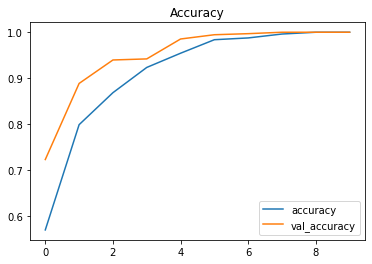

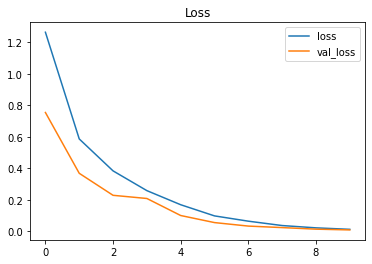

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

# Plotting loss and val_loss
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Calculating Test Accuracy and Loss
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.73740
Test Accuracy: 79.94%


In [ ]:
pred = model.predict(test_gen )
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
# Classification report
y_test = list(test_df['class'])
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

    bumper_dent       0.62      0.62      0.62        29
 bumper_scratch       0.82      0.82      0.82        38
      door_dent       0.58      0.83      0.68        30
   door_scratch       0.76      0.50      0.60        26
  glass_shatter       0.86      0.79      0.83        24
      head_lamp       0.77      0.77      0.77        26
multiple_damage       0.93      0.90      0.91       127
      tail_lamp       0.73      0.79      0.76        24

       accuracy                           0.80       324
      macro avg       0.76      0.75      0.75       324
   weighted avg       0.81      0.80      0.80       324



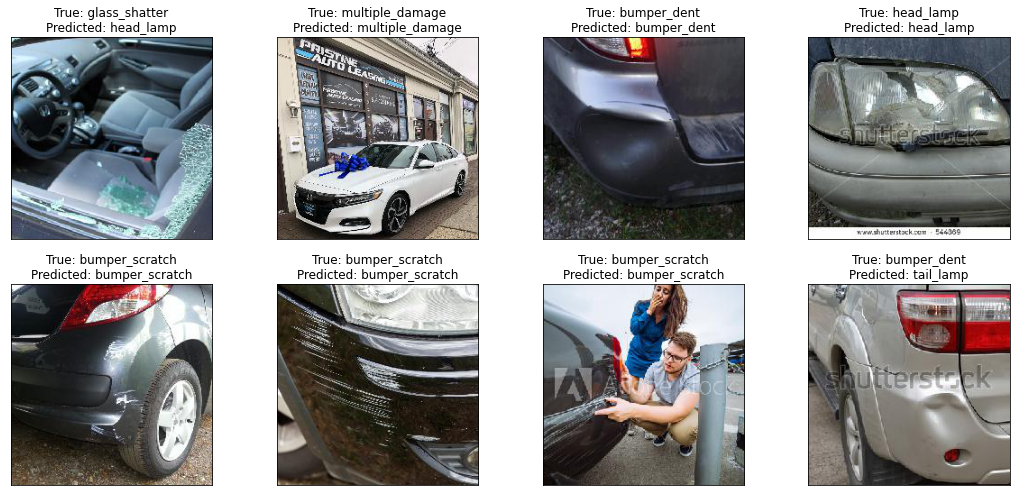

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.image.iloc[i]))
    ax.set_title(f"True: {test_df['class'].iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [ ]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_car_detection.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
